In [1]:
import numpy as np
import os
import sys
from PIL import Image
from numpy.fft import fft2, ifftshift, fftshift
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import k3d

In [69]:

wavesets = {
    'Hex_Fund': [
        [0.8660254037844385,-0.5, 0.0, -0.54,  0.8660254037844387, 0.0],
        [0.0,                 0.0, 0.0,   1.0,                 0.0, 0.0],
        [0.8660254037844385, 0.5, 0.0, -0.54, -0.8660254037844387, 0.0]],

    'Hex_Sparse1': [
        [1.0, 0.0, 0.0, 0.0, -1.0, 0.0],
        [0.5, 0.8660254037844384, 0.0, 0.8660254037844387, -0.5, 0.0],
        [0.5, -0.8660254037844385, 0.0, 0.8660254037844387, 0.5, 0.0]
    ],
    'Hex_Fund_MaxComp': [
        [1.0, 0.0, 0.0, 0.0, -1.0, 0.0],
        [0.5, 0.8660254037844384, 0.0, 0.8660254037844387, -0.5, 0.0],
        [0.5, -0.8660254037844385, 0.0, 0.8660254037844387, 0.5, 0.0],
        [1.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.5, 0.8660254037844384, 0.0, -0.8660254037844387, 0.5, 0.0],
        [0.5, -0.8660254037844385, 0.0, -0.8660254037844387, -0.5, 0.0]
    ],
    'Hex_Sparse1_MaxComp': [
        [0.8660254037844385, 0.5, 0.0, -0.54, 0.8660254037844387, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.8660254037844385, -0.5, 0.0, -0.54, -0.8660254037844387, 0.0],
        [0.8660254037844385, 0.5, 0.0, 0.54, -0.8660254037844387, 0.0],
        [0.0, 0.0, 0.0, -1.0, 0.0, 0.0],
        [0.8660254037844385, -0.5, 0.0, 0.54, 0.8660254037844387, 0.0]
    ],
    'Hex_Sparse2': [
        [0.18898223650461407, -0.9819805060619625, 0.0, 0.9819805060619656, 0.18898223650461363, 0.0],
        [0.18898223650461407, 0.9819805060619625, 0.0, 0.9819805060619656, -0.18898223650461363, 0.0],
        [0.7559289460184544, 0.654653670707977, 0.0, 0.6546536707079771, -0.7559289460184545, 0.0]
    ],
    'Hex_Sparse2_MaxComp': [
        [0.18898223650461407, -0.9819805060619625, 0.0, 0.9819805060619656, 0.18898223650461363, 0.0],
        [0.18898223650461407, 0.9819805060619625, 0.0, 0.9819805060619656, -0.18898223650461363, 0.0],
        [0.7559289460184544, 0.654653670707977, 0.0, 0.6546536707079771, -0.7559289460184545, 0.0],
        [0.18898223650461407, -0.9819805060619625, 0.0, -0.9819805060619656, -0.18898223650461363, 0.0],
        [0.18898223650461407, 0.9819805060619625, 0.0, -0.9819805060619656, 0.18898223650461363, 0.0],
        [0.7559289460184544, 0.654653670707977, 0.0, -0.6546536707079771, 0.7559289460184545, 0.0],
        [0.7559289460184544, -0.654653670707977, 0.0, -0.6546536707079771, -0.7559289460184545, 0.0],
        [0.7559289460184544, -0.654653670707977, 0.0, 0.6546536707079771, 0.7559289460184545, 0.0],
        [0.944911182523068, -0.3273268353539885, 0.0, 0.32732683535398854, 0.9449111825230679, 0.0],
        [0.944911182523068, -0.3273268353539885, 0.0, -0.32732683535398854, -0.9449111825230679, 0.0],
        [0.9449111825230679, 0.3273268353539886, 0.0, 0.32732683535398865, -0.944911182523068, 0.0],
        [0.9449111825230679, 0.3273268353539886, 0.0, -0.32732683535398865, 0.944911182523068, 0.0]
    ],

    'Sq_Fund': [
        [0.7071067811865476, 0.7071067811865472, 0.0, -0.7071067811865475, 0.7071067811865475, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, 0.7071067811865475, 0.7071067811865475, 0.0],
        [0.7071067811865476, 0.7071067811865472, 0.0, 0.7071067811865475, -0.7071067811865475, 0.0]
    ],

    'Sq_Sparse1': [
        [0.31622776601683783, 0.9486832980505125, 0.0, 0.9486832980505138, -0.31622776601683794, 0.0],
        [0.31622776601683783, -0.9486832980505125, 0.0, 0.9486832980505138, 0.31622776601683794, 0.0],
        [0.9486832980505138, -0.3162277660168379, 0.0, 0.31622776601683794, 0.9486832980505138, 0.0]
    ],

    'Sq_Sparse2': [
        [0.14142135623730964, 0.989949493661161, 0.0, 0.9899494936611665, -0.1414213562373095, 0.0],
        [0.14142135623730964, -0.989949493661161, 0.0, 0.9899494936611665, 0.1414213562373095, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, 0.7071067811865475, 0.7071067811865475, 0.0]
    ],
    'Sq_Fund_MaxComp': [
        [0.7071067811865476, 0.7071067811865472, 0.0, -0.7071067811865475, 0.7071067811865475, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, 0.7071067811865475, 0.7071067811865475, 0.0],
        [0.7071067811865476, 0.7071067811865472, 0.0, 0.7071067811865475, -0.7071067811865475, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, -0.7071067811865475, -0.7071067811865475, 0.0]
    ],
    'Sq_Sparse1_MaxComp': [
        [0.31622776601683783, 0.9486832980505125, 0.0, 0.9486832980505138, -0.31622776601683794, 0.0],
        [0.31622776601683783, -0.9486832980505125, 0.0, 0.9486832980505138, 0.31622776601683794, 0.0],
        [0.9486832980505138, -0.3162277660168379, 0.0, 0.31622776601683794, 0.9486832980505138, 0.0],
        [0.31622776601683783, 0.9486832980505125, 0.0, -0.9486832980505138, 0.31622776601683794, 0.0],
        [0.31622776601683783, -0.9486832980505125, 0.0, -0.9486832980505138, -0.31622776601683794, 0.0],
        [0.9486832980505138, -0.3162277660168379, 0.0, -0.31622776601683794, -0.9486832980505138, 0.0],
        [0.9486832980505138, 0.3162277660168379, 0.0, -0.31622776601683794, 0.9486832980505138, 0.0],
        [0.9486832980505138, 0.3162277660168379, 0.0, 0.31622776601683794, -0.9486832980505138, 0.0]
    ],
    'Sq_Sparse2_MaxComp': [
        [0.14142135623730964, 0.989949493661161, 0.0, 0.9899494936611665, -0.1414213562373095, 0.0],
        [0.14142135623730964, -0.989949493661161, 0.0, 0.9899494936611665, 0.1414213562373095, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, 0.7071067811865475, 0.7071067811865475, 0.0],
        [0.14142135623730964, 0.989949493661161, 0.0, -0.9899494936611665, 0.1414213562373095, 0.0],
        [0.14142135623730964, -0.989949493661161, 0.0, -0.9899494936611665, -0.1414213562373095, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, -0.7071067811865475, -0.7071067811865475, 0.0],
        [0.7071067811865476, 0.7071067811865472, 0.0, -0.7071067811865475, 0.7071067811865475, 0.0],
        [0.7071067811865476, 0.7071067811865472, 0.0, 0.7071067811865475, -0.7071067811865475, 0.0],
        [0.9899494936611665, -0.14142135623730948, 0.0, 0.1414213562373095, 0.9899494936611665, 0.0],
        [0.9899494936611665, 0.14142135623730948, 0.0, -0.1414213562373095, 0.9899494936611665, 0.0],
        [0.9899494936611665, -0.14142135623730948, 0.0, -0.1414213562373095, -0.9899494936611665, 0.0],
        [0.9899494936611665, 0.14142135623730948, 0.0, 0.1414213562373095, -0.9899494936611665, 0.0]
    ],
    'Sq_Fund_MaxComp_Rot45': [
        [0.7071067811865476, 0.7071067811865472, 0.0, -0.9999999999999999, 1.1102230246251565e-16, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, 1.1102230246251565e-16, 0.9999999999999999, 0.0],
        [0.7071067811865476, 0.7071067811865472, 0.0, 0.9999999999999999, -1.1102230246251565e-16, 0.0],
        [0.7071067811865476, -0.7071067811865472, 0.0, -1.1102230246251565e-16, -0.9999999999999999, 0.0]
    ],
    'Sq_Sparse1_MaxComp_Rot45': [
        [0.31622776601683783, 0.9486832980505125, 0.0, 0.8944271909999159, 0.4472135954999578, 0.0],
        [0.31622776601683783, -0.9486832980505125, 0.0, 0.447213595499958, 0.8944271909999157, 0.0],
        [0.9486832980505138, -0.3162277660168379, 0.0, -0.4472135954999578, 0.8944271909999159, 0.0],
        [0.31622776601683783, 0.9486832980505125, 0.0, -0.8944271909999159, -0.4472135954999578, 0.0],
        [0.31622776601683783, -0.9486832980505125, 0.0, -0.447213595499958, -0.8944271909999157, 0.0],
        [0.9486832980505138, -0.3162277660168379, 0.0, 0.4472135954999578, -0.8944271909999159, 0.0],
        [0.9486832980505138, 0.3162277660168379, 0.0, -0.8944271909999157, 0.447213595499958, 0.0],
        [0.9486832980505138, 0.3162277660168379, 0.0, 0.8944271909999157, -0.447213595499958, 0.0]
    ],
    'Hex_Fund_MaxComp_Rot90': [
        [1.0, 0.0, 0.0, 1.0, -6.123233995736766e-17, 0.0],
        [0.5, 0.8660254037844384, 0.0, 0.5, 0.8660254037844387, 0.0],
        [0.5, -0.8660254037844385, 0.0, -0.5, 0.8660254037844387, 0.0],
        [1.0, 0.0, 0.0, -1.0, 6.123233995736766e-17, 0.0],
        [0.5, 0.8660254037844384, 0.0, -0.5, -0.8660254037844387, 0.0],
        [0.5, -0.8660254037844385, 0.0, 0.5, -0.8660254037844387, 0.0]
    ],
    'Hex_Sparse2_MaxComp_Rot90': [
        [0.18898223650461407, -0.9819805060619625, 0.0, -0.18898223650461357, 0.9819805060619656, 0.0],
        [0.18898223650461407, 0.9819805060619625, 0.0, 0.18898223650461368, 0.9819805060619656, 0.0],
        [0.7559289460184544, 0.654653670707977, 0.0, 0.7559289460184545, 0.6546536707079771, 0.0],
        [0.18898223650461407, -0.9819805060619625, 0.0, 0.18898223650461357, -0.9819805060619656, 0.0],
        [0.18898223650461407, 0.9819805060619625, 0.0, -0.18898223650461368, -0.9819805060619656, 0.0],
        [0.7559289460184544, 0.654653670707977, 0.0, -0.7559289460184545, -0.6546536707079771, 0.0],
        [0.7559289460184544, -0.654653670707977, 0.0, 0.7559289460184545, -0.6546536707079771, 0.0],
        [0.7559289460184544, -0.654653670707977, 0.0, -0.7559289460184545, 0.6546536707079771, 0.0],
        [0.944911182523068, -0.3273268353539885, 0.0, -0.9449111825230679, 0.3273268353539886, 0.0],
        [0.944911182523068, -0.3273268353539885, 0.0, 0.9449111825230679, -0.3273268353539886, 0.0],
        [0.9449111825230679, 0.3273268353539886, 0.0, 0.944911182523068, 0.3273268353539886, 0.0],
        [0.9449111825230679, 0.3273268353539886, 0.0, -0.944911182523068, -0.3273268353539886, 0.0]
    ]
}

In [138]:
wave = 0.488
pixel = 13.665
mag = 167.364
shift_x = 0
shift_y = 0
NA_outer = 0.6
NA_ideal = 0.9
NA_inner = 0.505
tilt = 0
field_sign = 1
slm_xpix = 1280
slm_ypix = 1024
xyPol = (0, 1)
pos_offset = (0, 0)
bound = "gauss"
fill_factor = 0.75
crop = 0.15
index = 1.33  # refractive index of the imaging medium

ConeAng = np.arcsin(NA_ideal/index)  # cone angle of illumination in radians
# define the plot dimensions for the lattice:
SLMPixSize = pixel / mag  # SLM pixel size when projected to the sample, in microns
numpix = [int(slm_xpix/2), int(slm_ypix/2)]
pixsize = np.array([SLMPixSize, SLMPixSize]) / (wave / 1.33)


[[ 7.07106781e-01  7.07106781e-01  0.00000000e+00 -1.00000000e+00
   1.11022302e-16  0.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01  0.00000000e+00  1.11022302e-16
   1.00000000e+00  0.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  1.00000000e+00
  -1.11022302e-16  0.00000000e+00]
 [ 7.07106781e-01 -7.07106781e-01  0.00000000e+00 -1.11022302e-16
  -1.00000000e+00  0.00000000e+00]]


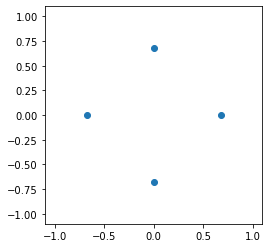

[[ 7.07106781e-01  7.07106781e-01  0.00000000e+00 -6.76691729e-01
   7.51278738e-17  7.36266462e-01]
 [ 7.07106781e-01 -7.07106781e-01  0.00000000e+00  7.51278738e-17
   6.76691729e-01  7.36266462e-01]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  6.76691729e-01
  -7.51278738e-17  7.36266462e-01]
 [ 7.07106781e-01 -7.07106781e-01  0.00000000e+00 -7.51278738e-17
  -6.76691729e-01  7.36266462e-01]]


In [139]:
PW = np.array(wavesets['Sq_Fund_MaxComp_Rot45'])
print(PW)

# ensure that the k vectors lie in a plane (i.e., cone angle = 90 deg):
PW[:, 3:5] = PW[:, 3:5] / np.sqrt(1 - PW[0, 5]**2)
PW[:, 5] = 0

# now modify each k vector to reflect the cone angle upon which they lie:
PW[:, 3:5] = np.sin(ConeAng) * PW[:, 3:5]
PW[:, 5] = np.cos(ConeAng)

# normalize the input polarization and make it a 1 x 3 vector:
xyPol = np.array(xyPol)
InputPol = np.array([xyPol[0], xyPol[1], 0])
InputPol = InputPol / np.linalg.norm(InputPol)

    
plt.figure()
slc = np.s_[:]
plt.scatter(*PW[slc, 3:5].T)
plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.gca().set_aspect('equal')
plt.show()
print(PW)


In [141]:
nbeams = PW.shape[0]
origin = (0,0,0)
plot = k3d.plot()
plot += k3d.vectors((origin, origin, origin),
                    [(1,0,0), (0,1,0), (0,0,1)],
                    color=0xcccccc)

for n in range(nbeams):
    # find the orthonormal vectors defining the coordinate system for the
    # nth beam when entering the rear pupil:
    beam = PW[n, 3:6]
    
    phivec = np.cross(beam, np.array([0, 0, 1]))
    # print(f"phivec: {phivec}")
    plot += k3d.vectors(origin, beam)
    # plot += k3d.vectors(beam, phivec, color=0xff0000)
    phivec = phivec / np.linalg.norm(phivec)  # azimuthal unit vector
    
    plot += k3d.vectors(beam, phivec, color=0xffff00)
    radvec = np.cross(np.array([0, 0, 1]), phivec)  # radial unit vector
    plot += k3d.vectors(beam, radvec, color=0x00ff00)

    ephi = np.dot(phivec, InputPol)
    
    # the radial component is tilted by refraction when passing through the
    # objective to point in the theta direcclose ation as defined by a spherical
    # coordinate system centered at the focal point:
    thetavec = np.cross(beam, phivec)
    etheta = np.dot(radvec, InputPol)
    plot += k3d.vectors(beam, thetavec, color=0x00ffff)
    
    # the sum of the azimuthal and theta components gives the total electric
    # field for the nth plane wave of the lattice:
    sum_ = ephi * phivec + etheta * thetavec
    # with unit strength
    sum_ /= np.linalg.norm(sum_)
    plot += k3d.vectors(beam, sum_, color=0x330033)
    PW[n, 0:3] = sum_
    
#     print(f"beam: {beam}")
#     print(f"phivec: {phivec}")
#     print(f"radvec: {radvec}")
#     print(f"InputPol: {InputPol}")
#     print(f"ephi: {ephi}")
#     print(f"thetavec: {thetavec}")
#     print(f"etheta: {etheta}")
#     print()

plot.display()

Output()

In [142]:
period = np.zeros((2, 2))
for m in range(2):   # loop thru both axes
    mindiff = 2      # difference must be < 2 for normalized k
    maxdiff = 0
    for n in range(nbeams):
        for q in range(nbeams):  # double loop thru all plane wave pairs
            # abs of the sum of the mth component of the nth and qth k vectors
            PWdiff = np.abs(PW[n, (m + 3)] - PW[q, (m + 3)])
#             print(f"m: {m}, n: {n}, q: {q}, PWdiff: {PWdiff}")
            if (PWdiff > 0.001) and (PWdiff < mindiff):
                # if difference non-zero yet smaller than the smallest
                # difference thus far then
                mindiff = PWdiff
            if PWdiff > maxdiff:
                # if difference is larger than the largest
                # difference thus far then
                maxdiff = PWdiff
    print(mindiff)
    print(maxdiff)
    period[0, m] = 1 / mindiff  # period in wavelengths along m axis
    period[1, m] = 1 / maxdiff  # confinement in wavelengths along m axis
    print(period)

0.676691729323308
1.3533834586466162
[[1.47777778 0.        ]
 [0.73888889 0.        ]]
0.676691729323308
1.3533834586466162
[[1.47777778 1.47777778]
 [0.73888889 0.73888889]]


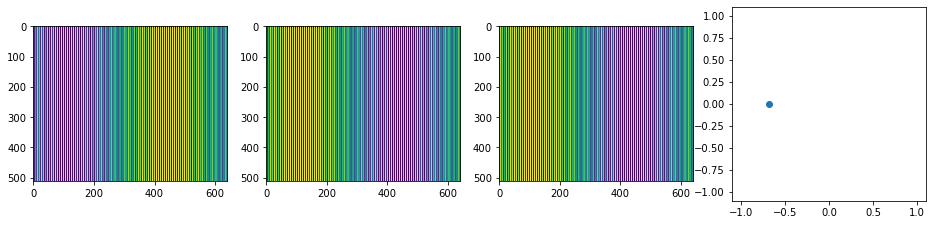

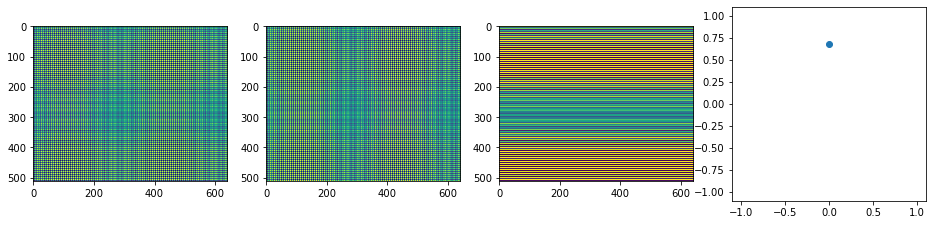

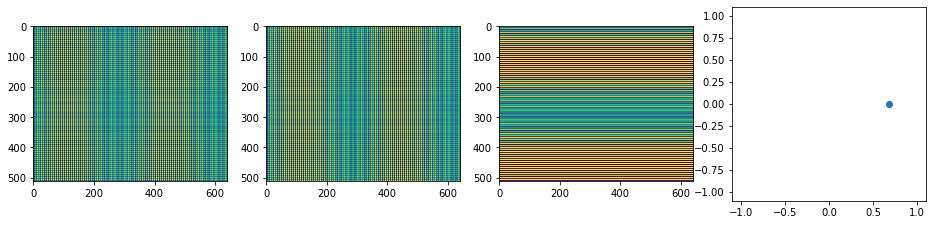

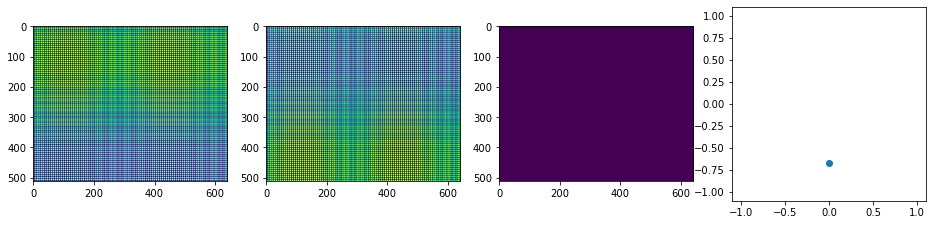

In [143]:
# calculate the complete electric field of the ideal 2D lattice:
x = pixsize[0] * np.arange(0, numpix[0] + 1) + pos_offset[0] * period[0, 0]
y = pixsize[1] * np.arange(0, numpix[1] + 1) + pos_offset[1] * period[0, 1]
[X, Y] = np.meshgrid(x, y)

# now calculate the E field at each mesh point:
A = X.shape
Ex = np.zeros(A)
Ey = np.zeros(A)
Ez = np.zeros(A)
for q in range(nbeams):   # loop thru all plane waves
    phase = np.exp(2 * np.pi * 1j * (PW[q, 3] * X + PW[q, 4] * Y))
    Ex = Ex + PW[q, 0] * phase
    Ey = Ey + PW[q, 1] * phase
    Ez = Ez + PW[q, 2] * phase
    f,(a1,a2,a3,a4) = plt.subplots(1,4, figsize=(16,16))
    a1.imshow(Ex.real)
    a2.imshow(Ey.real)
    a3.imshow(Ez.real)
    a4.scatter(*PW[q:q+1, 3:5].T)
    a4.set_xlim((-1.1, 1.1))
    a4.set_ylim((-1.1, 1.1))
    plt.gca().set_aspect('equal')

In [144]:
# expand through all quadrants:
Extemp = np.zeros(np.array(A)*2, dtype=np.complex128)
Eytemp = np.zeros(np.array(A)*2, dtype=np.complex128)
Eztemp = np.zeros(np.array(A)*2, dtype=np.complex128)
# load the original data into the first quadrant:
Extemp[A[0]:, A[1]:] = Ex
Eytemp[A[0]:, A[1]:] = Ey
Eztemp[A[0]:, A[1]:] = Ez
# f,(a1,a2,a3) = plt.subplots(1,3, figsize=(16,16))
# a1.imshow(Extemp.real)
# a2.imshow(Eytemp.real)
# a3.imshow(Eztemp.real)

In [145]:
# now mirror along each dimension and use parities to fill other quadrants:
# simply mirror the data since parity is always even for magnitudes:
Extemp[:A[0], A[1]:] = np.flip(Ex, 0)
Eytemp[:A[0], A[1]:] = np.flip(Ey, 0)
Eztemp[:A[0], A[1]:] = np.flip(Ez, 0)
Extemp[:, :A[1]] = np.flip(Extemp[:, A[1]:], 1)
Eytemp[:, :A[1]] = np.flip(Eytemp[:, A[1]:], 1)
Eztemp[:, :A[1]] = np.flip(Eztemp[:, A[1]:], 1)
# f,(a1,a2,a3) = plt.subplots(1,3, figsize=(16,16))
# a1.imshow(Extemp.real)
# a2.imshow(Eytemp.real)
# a3.imshow(Eztemp.real)
# Extemp.shape

(1025, 1281)

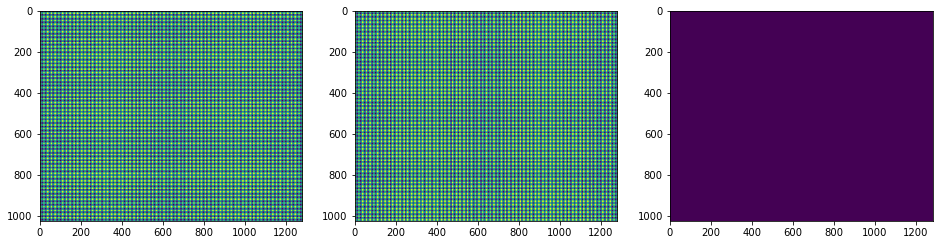

In [146]:
# delete the extra vector from mirroring in each dimension:
Extemp = np.delete(Extemp, A[0], 0)
Eytemp = np.delete(Eytemp, A[0], 0)
Eztemp = np.delete(Eztemp, A[0], 0)
Extemp = np.delete(Extemp, A[1], 1)
Eytemp = np.delete(Eytemp, A[1], 1)
Eztemp = np.delete(Eztemp, A[1], 1)
f,(a1,a2,a3) = plt.subplots(1,3, figsize=(16,16))
a1.imshow(Extemp.real)
a2.imshow(Eytemp.real)
a3.imshow(Eztemp.real)

Ex = Extemp
Ey = Eytemp
Ez = Eztemp
Extemp.shape


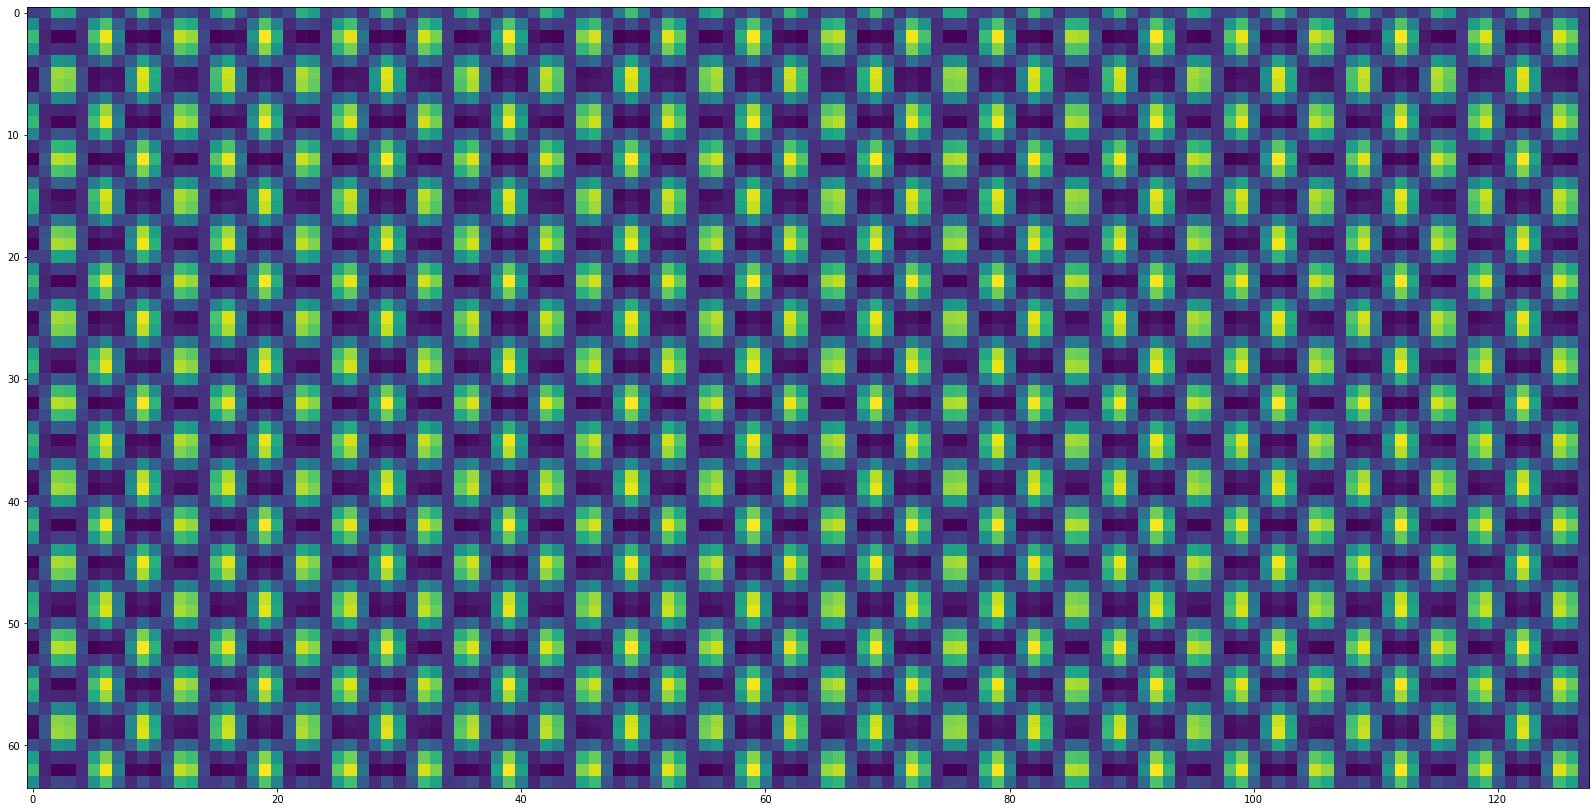

In [147]:
# find the ideal 2D lattice intensity:
A = Ex.shape
EComp = np.zeros((3, A[0], A[1])).astype(np.complex128)
EComp[0, :, :] = Ex
EComp[1, :, :] = Ey
EComp[2, :, :] = Ez
ESqTot = EComp * np.conj(EComp)
ESqTot = ESqTot.sum(0)
ESqTot /= ESqTot.max()
# plt.figure(figsize=(28,18))
# plt.imshow(EComp.sum(0).real[:64,:128])
plt.figure(figsize=(28,18))
# plt.imshow(ESqTot.real[:64,:128])
plt.imshow(ESqTot.real[ESqTot.shape[0]//2-32:ESqTot.shape[0]//2+32,:128])

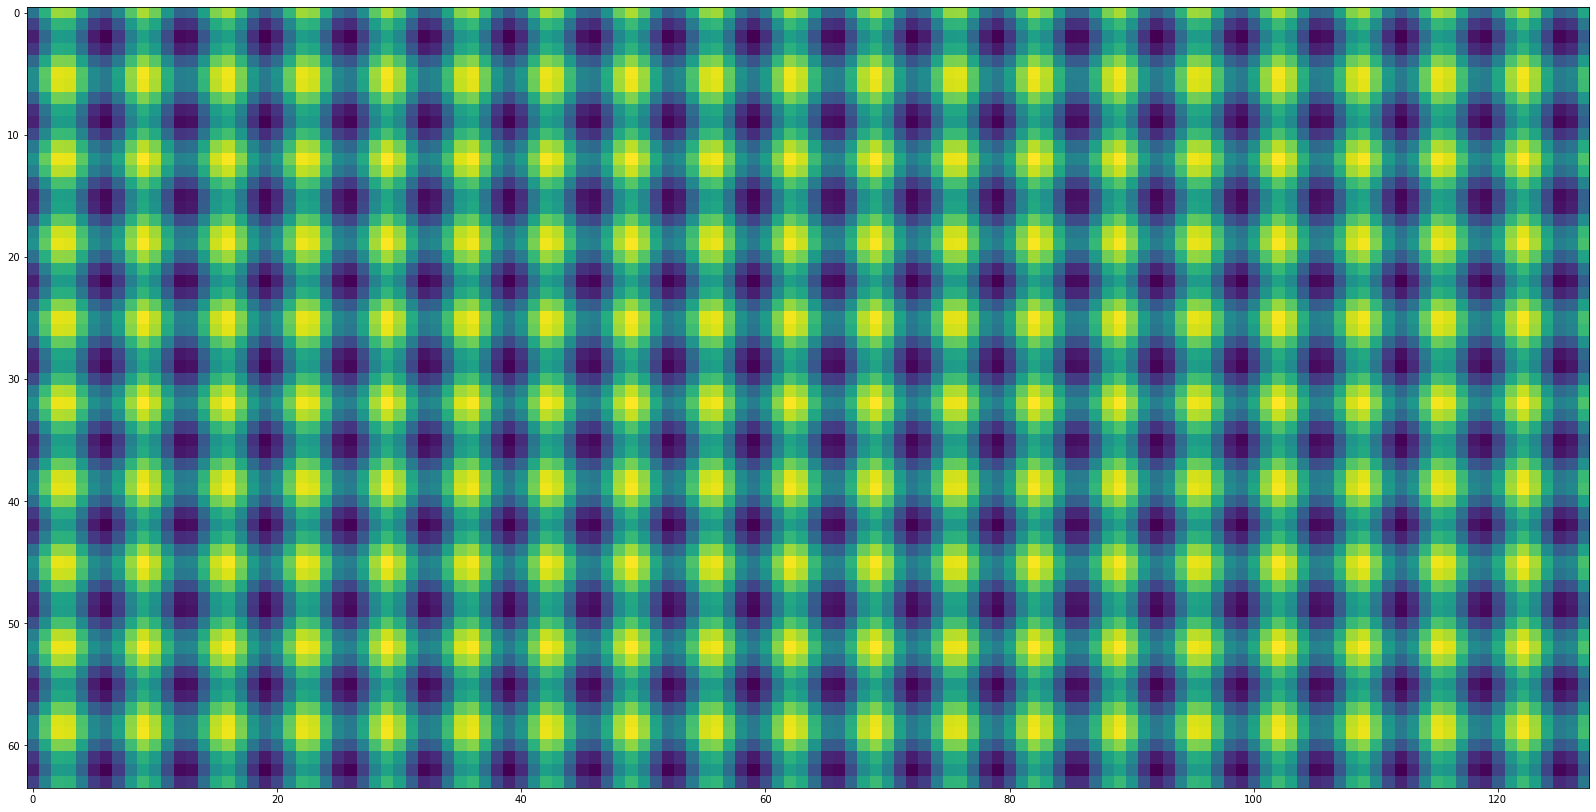

In [148]:

# calc and plot the ideal 2D lattice of the component of the real electric field
#   projected onto the state of the input electric field polarization:
if field_sign == 1:
    RealE = np.real(np.conj(Ex) * InputPol[0] + np.conj(Ey) * InputPol[1])
else:
    RealE = -np.real(np.conj(Ex) * InputPol[0] + np.conj(Ey) * InputPol[1])

plt.figure(figsize=(28,18))
plt.imshow(RealE[RealE.shape[0]//2-32:RealE.shape[0]//2+32,:128])

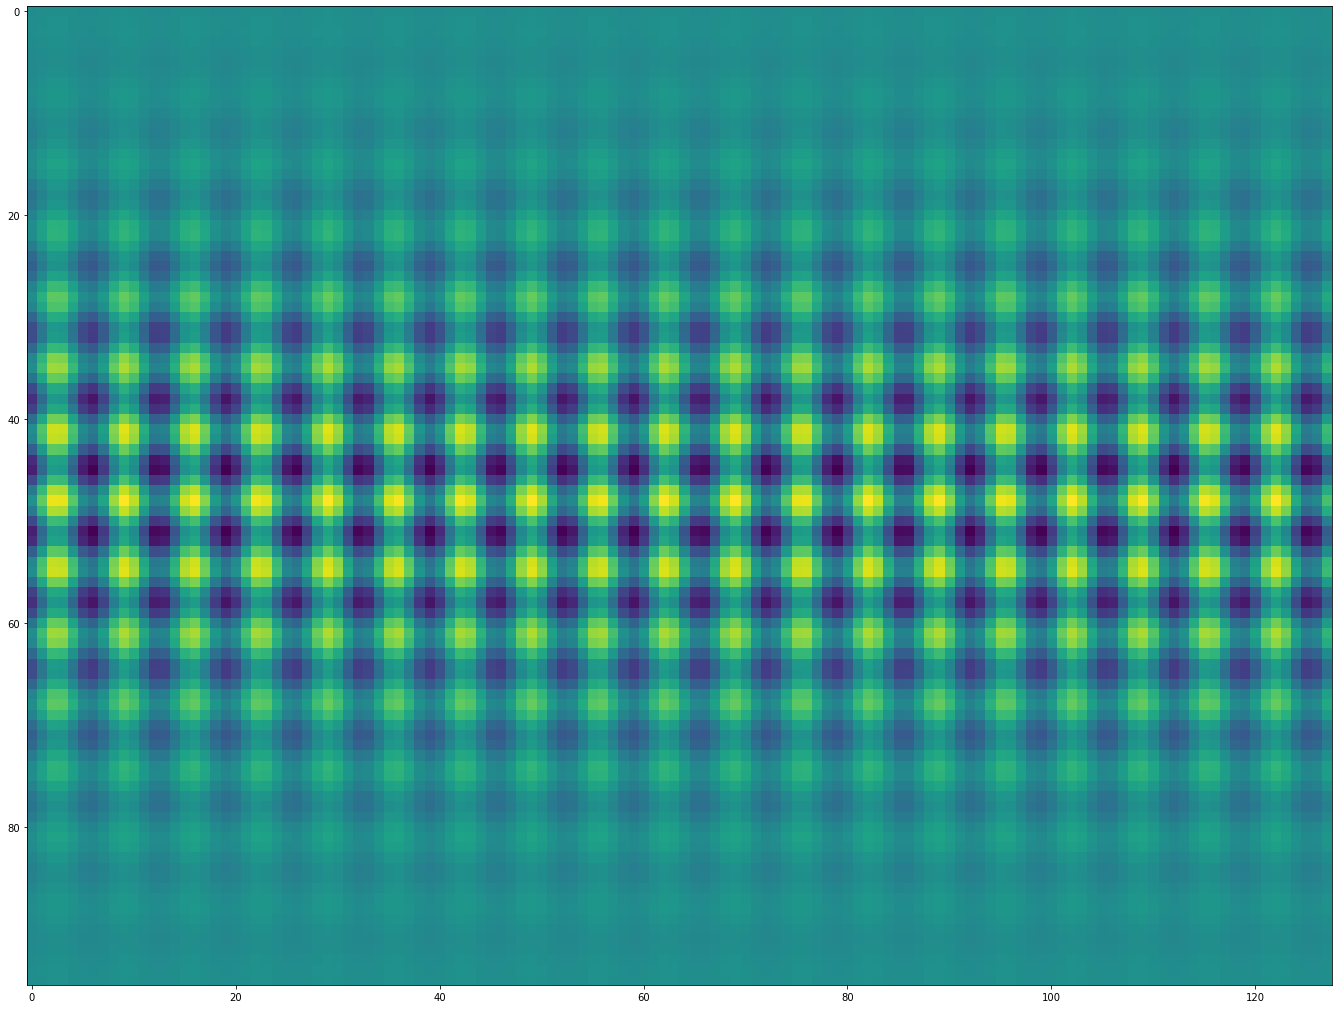

In [149]:
# find the required extent of the bound lattice at the SLM based on the
#    maximum and minimum NA at the rear pupil:
kxmax = 2 * np.pi * (NA_outer / index)
kxmin = 2 * np.pi * (NA_inner / index)
kxdiff = kxmax - kxmin
# approximate half width of the function limiting
# the extent of the bound lattice, in media wavelengths
lattice_full_width = np.pi / kxdiff

# calc and plot the bound 2D lattice at the SLM:
A = RealE.shape
if bound == 'step':
    maxzpix = int(lattice_full_width / (2 * pixsize[0] * fill_factor))
    midpix = int(A[0] / 2)
    RealE[:(midpix - maxzpix), :] = 0
    RealE[(midpix + maxzpix)+1:, :] = 0
elif bound == 'gauss':
    z = np.arange(-numpix[1], numpix[1]+1) * pixsize[1]
    sigma = lattice_full_width / np.sqrt(2 * np.log(2)) / fill_factor
    envelope = np.tile(np.exp(-2 * (z / sigma)**2), (A[1], 1))
    RealE = RealE * envelope.T
elif bound == 'none':
    pass
else:
    raise ValueError('bounding function value {} not one of \{step, gauss, none}', bound)

plt.figure(figsize=(28,18))
plt.imshow(RealE[RealE.shape[0]//2-48:RealE.shape[0]//2+48,:128])

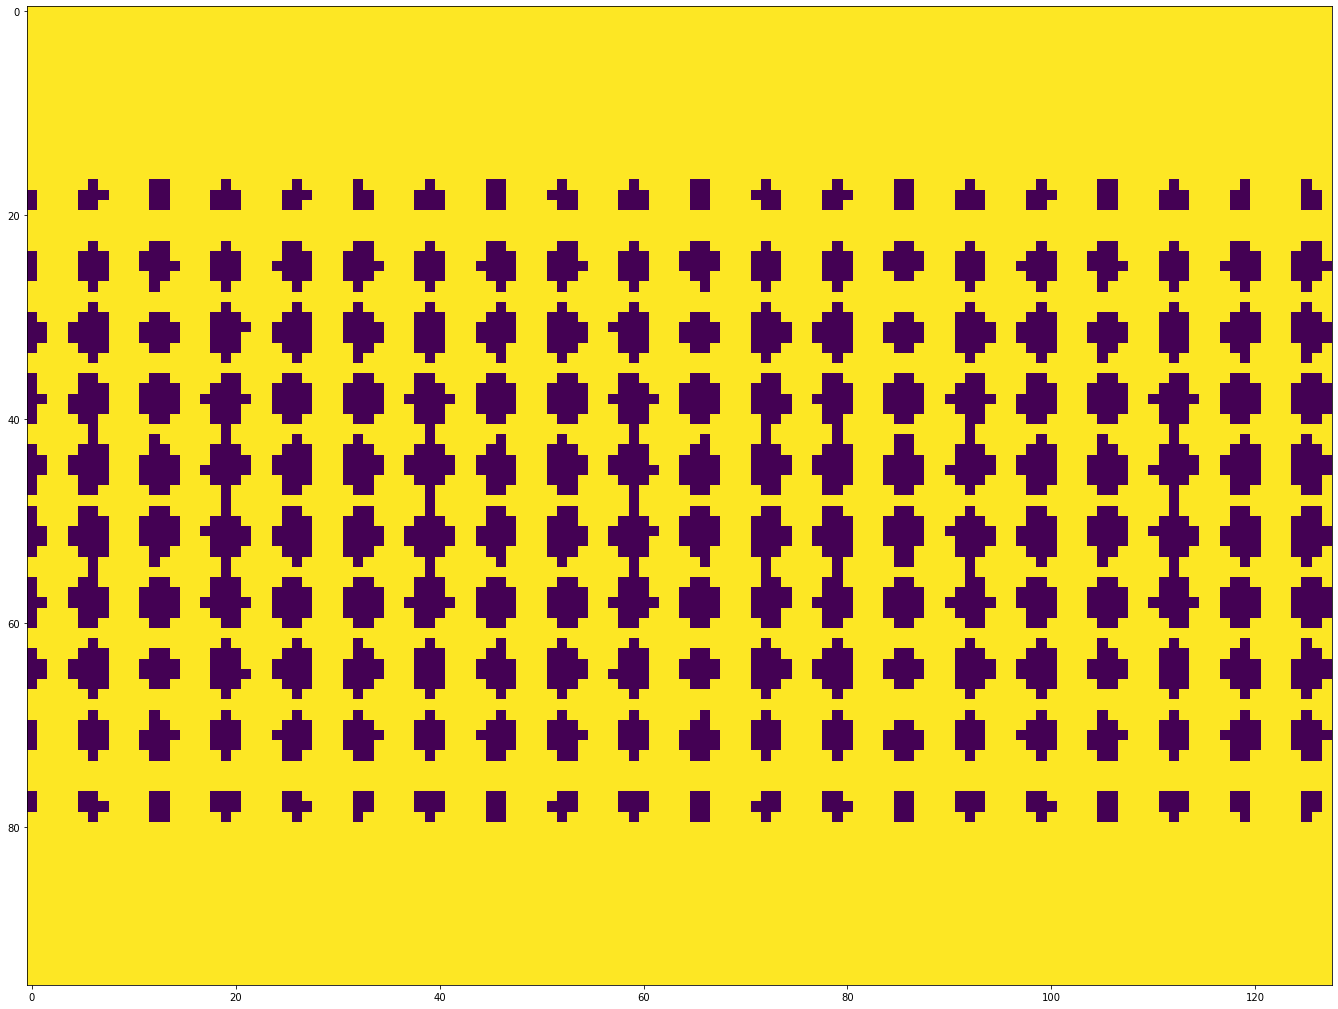

In [150]:
# now rotate the E field as needed to get the pattern in the same plane as the detection objective:
RotatedRealE = interpolation.rotate(RealE, -np.rad2deg(tilt), reshape=False)
# save the 4D SLM pattern:
RotatedRealE /= RotatedRealE.max()
# truncate any values below the level of crop:
RotatedRealE[np.abs(RotatedRealE) < crop] = 0
# now create the binary phase function (0 or pi) for the SLM:
eps = np.finfo(float).eps
SLMPattern = np.round(np.sign(RotatedRealE + eps) / 2 + 0.5)
SLMPattern = SLMPattern[:slm_ypix, :slm_xpix]
SLM_offsetY = int(shift_y * mag / pixel)
SLM_offsetX = int(shift_x * mag / pixel)
SLMPattern = np.roll(SLMPattern, SLM_offsetY, 0)  # y shift
SLMPattern = np.roll(SLMPattern, SLM_offsetX, 1)  # x shift

plt.figure(figsize=(28,18))
plt.imshow(SLMPattern[SLMPattern.shape[0]//2-48:SLMPattern.shape[0]//2+48,:128])